In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [24]:
df_master = pd.read_csv('Input/Historical Product Demand.csv', sep=",")
df_master.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100


## Preprocessing Data

In [25]:
df_master.shape

(1048575, 5)

In [26]:
df_master.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [27]:
df_master.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

### Handling Null Value

In [28]:
df_master.dropna(subset=['Date'], inplace=True)
df_master.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

### Non Numeric Data Handle

In [29]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

df_numeric = pd.DataFrame()
# Get Date
df_master['Date'] = pd.to_datetime(df_master['Date'])
df_numeric['MonthlyRequest'] = df_master['Date'].dt.month_name()


# Get Column non Numerical
cat_cols = [col for col in df_master.columns if df_master[col].dtype == 'object']

for col in cat_cols:
    df_numeric[col] = lb.fit_transform(df_master[col])

df_numeric.head(1)

,MonthlyRequest,Product_Code,Warehouse,Product_Category,Order_Demand
0,July,982,2,27,469


C:\Users\SYAR\AppData\Local\Temp\ipykernel_15204\3231702235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=monthly_demand.index, y=monthly_demand.values, palette='tab10')


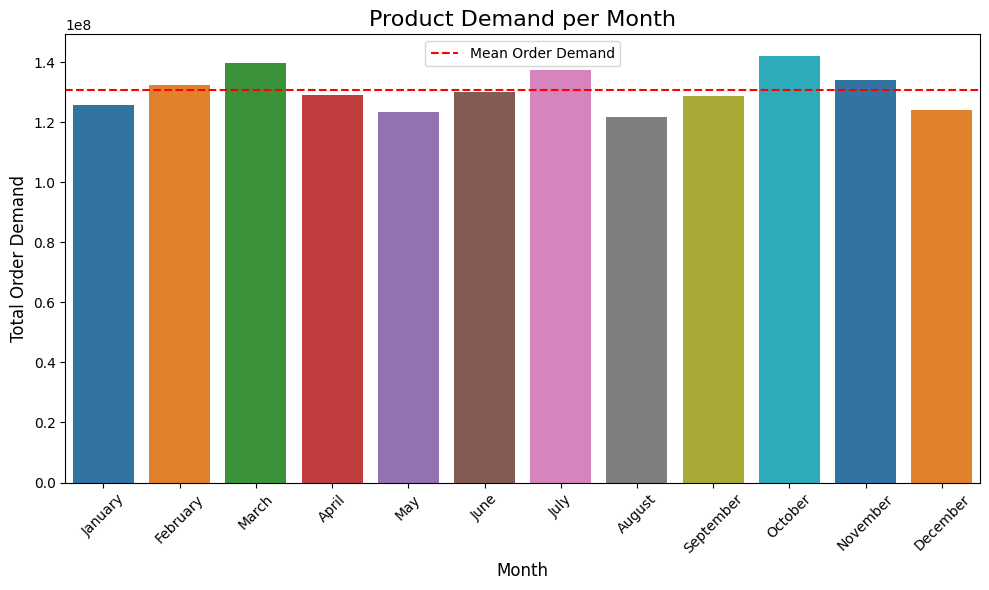

In [30]:
monthly_demand = df_numeric.groupby('MonthlyRequest')['Order_Demand'].sum().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

mean_demand = monthly_demand.mean()

plt.figure(figsize=(10, 6))
sn.barplot(x=monthly_demand.index, y=monthly_demand.values, palette='tab10')
plt.axhline(mean_demand, color='red', linestyle='--', label='Mean Order Demand')

plt.title('Product Demand per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Order Demand', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
df_numeric_x = df_numeric[df_numeric.columns[1:-1]]
df_numeric_y = df_numeric['Order_Demand']

df_numeric_x

,Product_Code,Warehouse,Product_Category
0,982,2,27
1,968,2,27
2,968,2,27
3,968,2,27
4,968,2,27
...,...,...,...
1048570,1780,2,5
1048571,1962,2,5
1048572,1776,2,5
1048573,890,2,22


## Check Feature

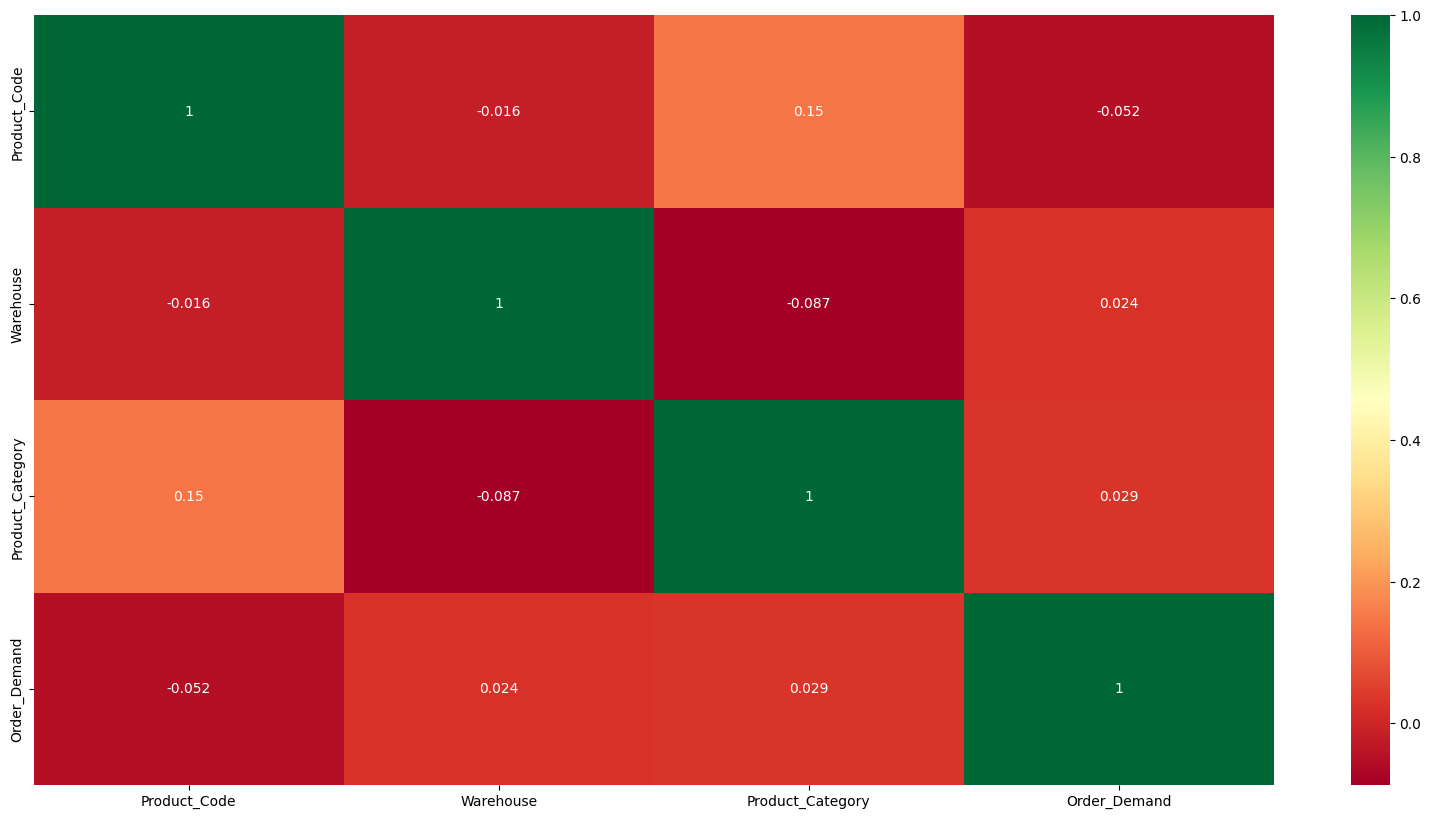

In [32]:
# Heatmap Check 

fig = plt.figure(figsize=(20,10))
corrMatrix = df_numeric[df_numeric.columns[1:]].corr()

sn.heatmap(corrMatrix,annot=True,cmap ='RdYlGn')
plt.show()

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#check best feature after k=9
bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(df_numeric_x,df_numeric_y)
dfscores = pd.DataFrame(fit.scores_)
fit = bestfeatures.fit(df_numeric_x,df_numeric_y)
dfcolumns = pd.DataFrame(df_numeric_x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Feature','Score']

print(featureScores.nlargest(4,'Score'))

c:\Users\SYAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=9 is greater than n_features=3. All the features will be returned.
  warnings.warn(
c:\Users\SYAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=9 is greater than n_features=3. All the features will be returned.
  warnings.warn(


            Feature         Score
0      Product_Code  2.727207e+07
2  Product_Category  6.190293e+05
1         Warehouse  5.215686e+04


In [34]:
from sklearn.model_selection import train_test_split


#Splitting Data to Learn
x_train, x_test, y_train, y_test = train_test_split(df_numeric_x, df_numeric_y, test_size=0.4, random_state= 100)

In [35]:
x_train.to_csv("Preprocessing Result/warehouse_demand/x_train_data.csv", sep=',', index=False)
y_train.to_csv("Preprocessing Result/warehouse_demand/y_train_data.csv", sep=',', index=False)
x_test.to_csv('Preprocessing Result/warehouse_demand/x_test_data.csv', sep=',', index=False)
y_test.to_csv('Preprocessing Result/warehouse_demand/y_test_data.csv', sep=',', index=False)

### Normalize Data

In [36]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler or Normalization Choosen because we want to use Neural Network Related Algorithm
norm_scaler = MinMaxScaler()

x_train['Demands'] = y_train
x_test['Demands'] = y_test

x_train_normalize = pd.DataFrame(norm_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_normalize = pd.DataFrame(norm_scaler.fit_transform(x_test), columns=x_test.columns)

x_train_normalize.head(1)

,Product_Code,Warehouse,Product_Category,Demands
0,0.686429,0.666667,0.5625,0.555229


In [37]:
x_train_normalize.to_csv("Normalization/warehouse_demand/x_train_data.csv", sep=',', index=False)
x_test_normalize.to_csv('Normalization/warehouse_demand/x_test_data.csv', sep=',', index=False)

### Forecast Model

In [38]:
import tensorflow as tf
from keras.layers import Dense, LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [62]:
x_train_normalize_list = x_train_normalize.values.tolist()
x_test_normalize_list = x_test_normalize.values.tolist()

x_train_normalize_list

[[0.6864289022695692, 0.6666666666666666, 0.5625, 0.5552294557097118],
 [0.3459935155164428, 0.6666666666666666, 0.0, 0.3959445037353255],
 [0.9268179712830014, 0.6666666666666666, 0.125, 0.8078975453575241],
 [0.3798054654932839, 0.6666666666666666, 0.0, 0.12459978655282818],
 [0.1987031032885595, 0.6666666666666666, 0.125, 0.738794023479189],
 [0.7605372857804539, 0.6666666666666666, 0.5625, 0.658751334044824],
 [0.8300138953219083, 0.6666666666666666, 0.15625, 0.12459978655282818],
 [0.05187586845761927, 0.6666666666666666, 0.15625, 0.12540021344717184],
 [0.07318202871699861, 1.0, 0.625, 0.39621131270010673],
 [0.44928207503473827, 0.0, 0.84375, 0.7761472785485592],
 [0.14219546086150997, 0.0, 0.71875, 0.27588046958377804],
 [0.6252894858730894, 0.6666666666666666, 1.0, 0.12566702241195304],
 [0.6243631310792033, 0.6666666666666666, 0.5625, 0.5552294557097118],
 [0.7128300138953219, 0.6666666666666666, 0.5625, 0.27614727854855925],
 [0.9069013432144511, 0.6666666666666666, 0.125, 0

In [63]:
def create_sequences(data, time_steps=1):
    X, y = [], []

    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30 
X, y = create_sequences(x_train_normalize_list, time_steps)
X_test, y_test = create_sequences(x_test_normalize_list, time_steps)

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(622371, 30, 4) (622371, 4)
(414905, 30, 4) (414905, 4)


In [67]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [68]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(60))
model.add(Dense(25))
model.add(Dense(X.shape[2]))

optimizer = Adam(learning_rate=0.02)
model.compile(optimizer=optimizer, loss="mean_squared_error")
model.summary()

c:\Users\SYAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 60)         │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 25)             │         1,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,269 (180.74 KB)

 Trainable params: 46,269 (180.74 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = model.fit(
    X, y,
    epochs=50, 
    batch_size=30,  # Batch size, tune this for better results
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1  # Shows the training process
)

Epoch 1/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 374s 18ms/step - loss: 0.0689 - val_loss: 0.0671
Epoch 2/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 372s 18ms/step - loss: 0.0678 - val_loss: 0.0675
Epoch 3/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 372s 18ms/step - loss: 0.0679 - val_loss: 0.0675
Epoch 4/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 373s 18ms/step - loss: 0.0678 - val_loss: 0.0675
Epoch 5/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 376s 18ms/step - loss: 0.0678 - val_loss: 0.0682
Epoch 6/50
20746/20746 ━━━━━━━━━━━━━━━━━━━━ 377s 18ms/step - loss: 0.0679 - val_loss: 0.0675


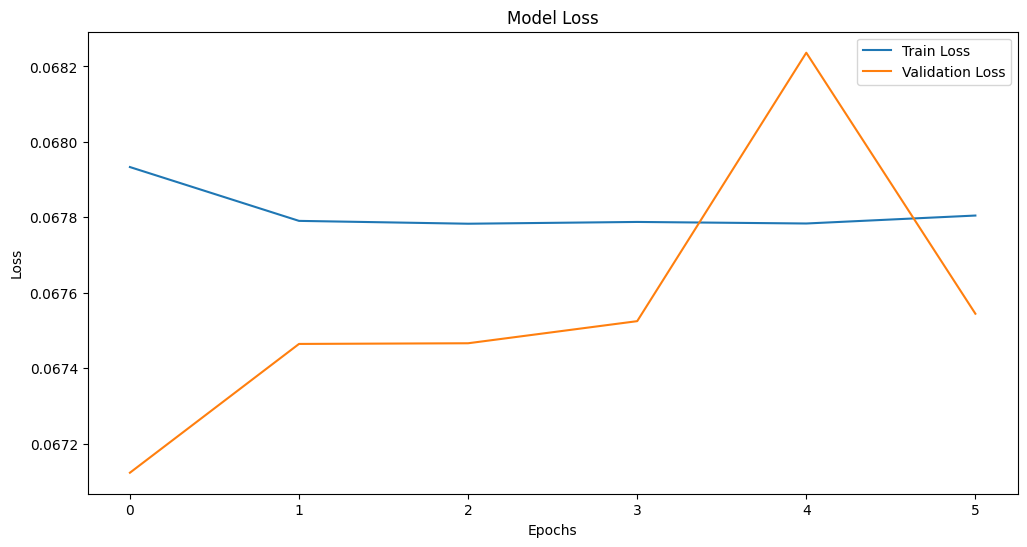

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [90]:
y_pred = model.predict(X_test)
print(y_pred.shape)


12966/12966 ━━━━━━━━━━━━━━━━━━━━ 126s 10ms/step
(414905, 4)


In [88]:
predict = norm_scaler.inverse_transform(y_pred)
predict

array([[1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ],
       [1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ],
       [1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ],
       ...,
       [1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ],
       [1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ],
       [1101.9004   ,    1.7889192,   14.091886 , 1560.4789   ]],
      dtype=float32)

In [91]:
model.save('Output Model/Warehouse Demands/lstm_model.h5')

## Logitic Regression

In [ ]:
x_train_normalize['Time'] = (df_master['Date'] - df_master['Date'].min()) / np.timedelta64(1, 'D')
x_test_normalize.dropna(subset=['Time'], inplace=True)
x_train_normalize['Time'] = x_train_normalize['Time'].astype(int)

print (x_train_normalize.head(15))

KeyError: ['Time']

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



model = LinearRegression()
model.fit(x_train_normalize[x_train_normalize.columns[0:-1]], x_train_normalize[x_train_normalize.columns[-1:]])


ValueError: Input y contains NaN.

In [ ]:
# Predict using the model
y_pred = model.predict(x_test_normalize[x_test_normalize.columns[0:-1]])

rmse = np.sqrt(mean_squared_error(x_test_normalize[x_test_normalize.columns[-1:]], y_pred))
print("RMSE: ", rmse)

RMSE:  0.25958602206680037


In [118]:
y_pred

array([[0.39482618],
       [0.40973492],
       [0.42957986],
       ...,
       [0.38738613],
       [0.40711064],
       [0.43001042]])

In [119]:
y_test = x_test_normalize[x_test_normalize.columns[-1:]]
y_test = y_test.values.tolist()

y_test

[[0.1251334044823906],
 [0.1251334044823906],
 [0.738794023479189],
 [0.12540021344717184],
 [0.12566702241195304],
 [0.39647812166488794],
 [0.7393276414087514],
 [0.23185699039487728],
 [0.3967449306296692],
 [0.3959445037353255],
 [0.12540021344717184],
 [0.12566702241195304],
 [0.3956776947705443],
 [0.1251334044823906],
 [0.12540021344717184],
 [0.12540021344717184],
 [0.12566702241195304],
 [0.46691568836712916],
 [0.1251334044823906],
 [0.5544290288153683],
 [0.9100853788687301],
 [0.6579509071504803],
 [0.7385272145144077],
 [0.6584845250800427],
 [0.1248665955176094],
 [0.1248665955176094],
 [0.8633938100320171],
 [0.7393276414087514],
 [0.7393276414087514],
 [0.27614727854855925],
 [0.8073639274279616],
 [0.1248665955176094],
 [0.12459978655282818],
 [0.7395944503735326],
 [0.738794023479189],
 [0.12540021344717184],
 [0.5301494130202775],
 [0.6584845250800427],
 [0.7385272145144077],
 [0.1251334044823906],
 [0.12566702241195304],
 [0.7390608324439701],
 [0.916221985058698],


In [125]:
import joblib 

joblib.dump(model,'Output Model/Warehouse Demands/regression_model.pkl')

['Output Model/Warehouse Demands/regression_model.pkl']

In [132]:
df_master.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100


In [ ]:
df_master['Time'

future_times = np.array([X['Time'].max() + i for i in range(1, 31)]).reshape(-1, 1)
future_predictions = model.predict(future_times)
future_predictions = np.round(future_predictions, 2)
print("Future Predictions: ", future_predictions)
